# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [153]:
import numpy as np
from glob import glob
import os

print(os.getcwd())

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

breeds = np.array([i.split('/') for i in dog_files])
breeds = breeds[:, 2]
unique, counts = np.unique(breeds, return_counts=True)

mydict = dict(zip(unique, counts))
for key in sorted(mydict):
    print("%s: %d" % (key, mydict[key]))

/home/ec2-user/SageMaker/deep-learning-v2-pytorch/project-dog-classification
There are 13233 total human images.
There are 8351 total dog images.
001.Affenpinscher: 80
002.Afghan_hound: 73
003.Airedale_terrier: 65
004.Akita: 79
005.Alaskan_malamute: 96
006.American_eskimo_dog: 80
007.American_foxhound: 63
008.American_staffordshire_terrier: 82
009.American_water_spaniel: 42
010.Anatolian_shepherd_dog: 62
011.Australian_cattle_dog: 83
012.Australian_shepherd: 83
013.Australian_terrier: 58
014.Basenji: 86
015.Basset_hound: 92
016.Beagle: 74
017.Bearded_collie: 77
018.Beauceron: 63
019.Bedlington_terrier: 60
020.Belgian_malinois: 78
021.Belgian_sheepdog: 80
022.Belgian_tervuren: 59
023.Bernese_mountain_dog: 81
024.Bichon_frise: 77
025.Black_and_tan_coonhound: 46
026.Black_russian_terrier: 51
027.Bloodhound: 80
028.Bluetick_coonhound: 44
029.Border_collie: 93
030.Border_terrier: 65
031.Borzoi: 70
032.Boston_terrier: 81
033.Bouvier_des_flandres: 56
034.Boxer: 80
035.Boykin_spaniel: 66
036.B

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [4]:
!pip install opencv-python

    100% |████████████████████████████████| 28.2MB 1.7MB/s eta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Number of faces detected: 1


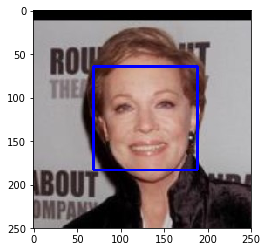

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Good human predictions:  98 %
Good non-dog predictions:  86 %

In [7]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
num_good_human_pred = 0
for file in human_files_short:
    if face_detector(file):
        num_good_human_pred += 1

num_good_dog_pred = 0
for file in dog_files_short:
    if face_detector(file) != True:
        num_good_dog_pred += 1
        
print("Good human predictions: ", num_good_human_pred, "%")
print("Good non-dog predictions: ", num_good_dog_pred, "%")

Good human predictions:  98 %
Good non-dog predictions:  86 %


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
!conda install -y pytorch -c pytorch
!pip install torchvision

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/mxnet_p36

  added / updated specs: 
    - pytorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         156 KB
    openssl-1.0.2u             |       h7b6447c_0         3.1 MB
    pytorch-1.4.0              |py3.6_cuda10.1.243_cudnn7.6.3_0       432.9 MB  pytorch
    ------------------------------------------------------------
                                           Total:       436.2 MB

The following NEW packages will be INSTALLED:

    cudatoolkit:     10.1.243-h6bb024c_0                          
    ninja:           1.9.0-py36hfd86e86_0                

In [9]:
import torch
import torchvision.models as models
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:24<00:00, 23.0MB/s] 


True


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path)
    normalize = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    imgTensor = normalize(img)
    imgTensor.unsqueeze_(0)
    if use_cuda:
        imgTensor = imgTensor.cuda()
    output = VGG16(imgTensor)
    _, pred = torch.max(output, 1) 
    if use_cuda:
        pred = pred.cpu()
    return pred.numpy()[0] # predicted class index

VGG16_predict("dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")

252

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    dog = False
    index = VGG16_predict(img_path)
    if index >= 151 and index <= 268:
        dog = True
        
    return dog # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 0% of images in human_files_short have detected a dog.  96% of dogs have been detected in dogs_file_short.


In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
num_good_human_pred = 0
for file in human_files_short:
    print ("-", end="")
    if dog_detector(file) == False:
        num_good_human_pred += 1

print()
num_good_dog_pred = 0
for file in dog_files_short:
    print ("-", end="")
    if dog_detector(file):
        num_good_dog_pred += 1

print() 
print("Good human predictions: ", num_good_human_pred, "%")
print("Good non-dog predictions: ", num_good_dog_pred, "%")

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Good human predictions:  100 %
Good non-dog predictions:  96 %


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [16]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [34]:
import torch

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [103]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import torchvision.models as models

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# define dataloader parameters
batch_size = 20
num_workers=0
image_size=256
train_dir = "dogImages/train"
valid_dir = "dogImages/valid"
test_dir = "dogImages/test"

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((image_size, image_size)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

eval_transform = transforms.Compose([
    #transforms.RandomRotation(10),
    transforms.Resize((image_size, image_size)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=eval_transform)
test_data = datasets.ImageFolder(test_dir, transform=eval_transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = {'train': train_loader,
                      'valid': valid_loader,
                      'test': test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:  The code applies a random resize crop transform on all images to 256x256 which was a good intermediate size based on the various sizes of the input images.  The input data had images with dimensions ranging from 100x100 to 2000x2000 so an intermediate figure had to be used.  Also we needed to be mindful of the input size into the CNN.  We didn't want that to be too large or it would cause the training to be slower.  Before the resize we do a random image rotation for training.  After that we do a horizontal flip so we can detect dogs oriented different ways.  Then we convert to tensor and apply a pixel rgb normalization in the rough range from 0 to 1.  The training set has more transforms to help the training, but these aren't needed for evaluation with the validation and test datasets.  This includes horizontal flipping and rotation.

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

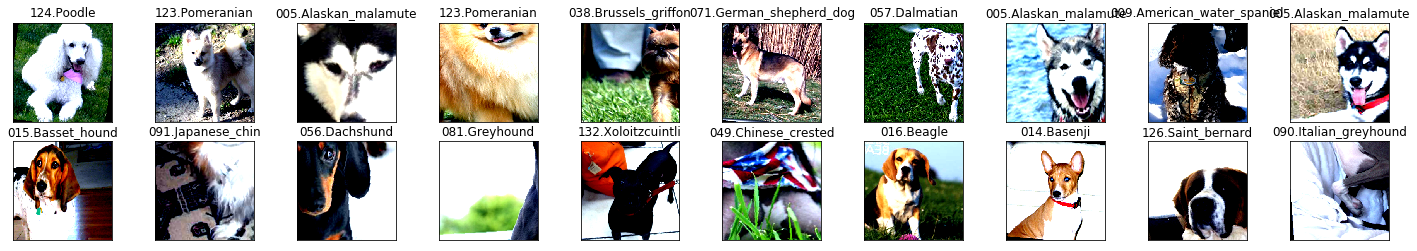

In [105]:
import numpy as np

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])    
    ax.set_title(train_data.classes[labels[idx]])

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [107]:
import torch.nn as nn
import torch.nn.functional as F

# hyperparameters
num_conv_layers=3
kernel_size=3
init_num_features=16
second_linear_size=1000
dropout=0.2

# computed sizes based on hyperparameters
final_dim=int(image_size/(2**num_conv_layers))
input_linear_size=int(init_num_features*(2**(num_conv_layers-1)) * final_dim**2)

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(3, init_num_features, kernel_size, padding=1)
        # convolutional layer (sees 128x128x16 image tensor)
        self.conv2 = nn.Conv2d(init_num_features, init_num_features*2, kernel_size, padding=1)
        # convolutional layer (sees 64x64x32 tensor)
        self.conv3 = nn.Conv2d(init_num_features*2, init_num_features*4, kernel_size, padding=1)
        # convolutional layer (sees 32x32x64 tensor)
        self.conv4 = nn.Conv2d(init_num_features*4, init_num_features*8, kernel_size, padding=1)
        # convolutional layer (sees 16x16x128 tensor)
        self.conv5 = nn.Conv2d(init_num_features*8, init_num_features*16, kernel_size, padding=1)
        # convolutional layer (sees 8x8x256 tensor)
        self.conv6 = nn.Conv2d(init_num_features*16, init_num_features*32, kernel_size, padding=1)
        
        self.conv_batch1 = nn.BatchNorm2d(init_num_features)
        self.conv_batch2 = nn.BatchNorm2d(init_num_features*2)
        self.conv_batch3 = nn.BatchNorm2d(init_num_features*4)
        self.conv_batch4 = nn.BatchNorm2d(init_num_features*8)
        self.conv_batch5 = nn.BatchNorm2d(init_num_features*16)
        self.conv_batch6 = nn.BatchNorm2d(init_num_features*32)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer
        self.fc1 = nn.Linear(input_linear_size, second_linear_size)
        # linear layer
        self.fc2 = nn.Linear(second_linear_size, len(train_data.classes))
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        #print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_batch1(x)
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_batch2(x)
        #print(x.size())
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_batch3(x)
        #print(x.size())
        #x = self.pool(F.relu(self.conv4(x)))
        #x = self.conv_batch4(x)
        #print(x.size())
        #x = self.pool(F.relu(self.conv5(x)))
        #x = self.conv_batch5(x)
        #print(x.size())
        #x = self.pool(F.relu(self.conv6(x)))
        #x = self.conv_batch6(x)
        #print(x.size())
        # flatten image input
        x = x.view(-1, input_linear_size)
        #print(x.size())
        # add dropout layer
        x = self.dropout(x)
        #print(x.size())
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        #print(x.size())
        # add dropout layer
        x = self.dropout(x)
        #print(x.size())
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        #print(x.size())
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_batch5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_batch6): BatchNorm2d(512, eps=1e-0

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I setup a standard 3 layer convolutional network with maxpool layers in between and linear layer at the end to start with.  I performed many experiments with different number of convolutional layers and number of linear layers from 1-6 convolutional layers to 1-2 linear layers and 0-6 batchnorm layers.  I always had maxpool layers for each convo layer.  I also experimented with various dropout ratios from 0.2 to 0.5.  Since I was varying these hyperparameters so much I wrote the model in a way that would require minimal changes when I decided to change the number of convo layers for instance.  I also varied the number of initial features in the first convo layer, the input size of the image, the learning rate, whether to do horizontal flipping, and whether to do batch normalization.  Hyperparameter tuning took quite a while and quite a large number of runs.  I eventually switched to gpu which sped up processing by a factor of 10, so nice.  I eventually found a winning configuration using 3 convo layers, 2 linear layers, and the rest of the settings shown above.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [109]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [110]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        print("train:", end="")
        for batch_idx, (data, target) in enumerate(loaders['train']):
            print("-", end="")
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            #train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        print("")
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        print("valid:", end="")
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            print("-", end="")
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            #valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        print("")
                
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        else:
            torch.save(model.state_dict(), "latest_"+save_path)

    # return trained model
    return model


In [111]:
# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

train:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
valid:------------------------------------------
Epoch: 1 	Training Loss: 4.720171 	Validation Loss: 4.540076
Validation loss decreased (inf --> 4.540076).  Saving model ...
train:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
valid:------------------------------------------
Epoch: 2 	Training Loss: 4.476272 	Validation Loss: 4.410474
Validation loss decreased (4.54007

In [112]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [113]:
import numpy as np

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [114]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.824002


Test Accuracy: 13% (117/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [23]:
## TODO: Specify data loaders
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import torchvision.models as models

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# define dataloader parameters
batch_size = 20
num_workers=0
image_size=224
train_dir = "dogImages/train"
valid_dir = "dogImages/valid"
test_dir = "dogImages/test"

data_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((image_size, image_size)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_transfer = {'train': train_loader,
                      'valid': valid_loader,
                      'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [24]:
import torchvision.models as models
import torch.nn as nn

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

## TODO: Specify model architecture 
vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(train_data.classes))

vgg16.classifier[6] = last_layer
print(vgg16)

model_transfer = vgg16
if use_cuda:
    model_transfer = model_transfer.cuda()

True
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I used the VGG16 model to start, just changing the last linear layer to match our classification problem.  I did training on only the last layer as VGG16 at its base already knows all about dogs from its previous extensive training.  I used basically the same data loaders as before as they worked well.  This architecture works well and is perfect for transfer learning since VGG16 is so applicable for image classification of everyday images like dogs.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [25]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [26]:
# train the model
n_epochs=10
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

train:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
valid:------------------------------------------
Epoch: 1 	Training Loss: 4.350677 	Validation Loss: 3.563588
Validation loss decreased (inf --> 3.563588).  Saving model ...
train:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
valid:------------------------------------------
Epoch: 2 	Training Loss: 2.979067 	Validation Loss: 2.318542
Validation loss decreased (3.56358

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.104315


Test Accuracy: 69% (585/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [137]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    normalize = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    imgTensor = normalize(img)
    imgTensor.unsqueeze_(0)
    if use_cuda:
        imgTensor = imgTensor.cuda()
    output = model_transfer(imgTensor)
    _, pred = torch.max(output, 1) 
    if use_cuda:
        pred = pred.cpu()
    return pred.numpy()[0] # predicted class index


# ---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [139]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from IPython.display import Image as img
from IPython.display import display

def run_app(img_path):
    human = False
    breed = None
    
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        breed = predict_breed_transfer(img_path)
    elif face_detector(img_path):
        human = True
        breed = predict_breed_transfer(img_path)
        
    if breed == None:
        print("Error, no dog or human detected.")
    elif human == False:
        print(img_path, ":  Dog detected, breed found to be ", class_names[breed])
    else:
        print(img_path, ":  Human detected, resembling breed found to be ", class_names[breed])
        
    display(img(filename=img_path))
    
    return breed

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is very good and somewhat what I expected.  There are ways to improve on the algorithm:

1.  Better recognition of the cropping area of the figure to be trained on and or evaluated.  Right now training is done with a random resize crop.  But similar to the way OpenCV does with faces, it should be possible to figure out the dimensions of the dog of interest and crop there.  This will lead to be a better trained and higher performing model.
2.  Add to training set and add epochs to train for.  By adding more training set images we can train better.  We can synthetically do this by adding pictures which are horizontally flipped and transformed in other ways if other test data is not available.  Also for training I stopped at 20 epochs but the loss was still decreasing so continuing may have helped performance.
3.  Adding to training of the base VGG16 model.  In the project we only trained the last linear layer.  Instead we could have tried training the rest of the model further with the training data.  This should improve the results as we are further customizing the model for our problem domain.

Adam_Sandler_0002.jpg :  Human detected, resembling breed found to be  Dachshund


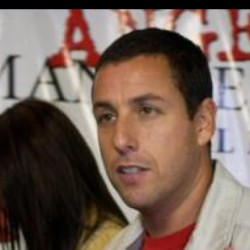

John_Lennon_0001.jpg :  Human detected, resembling breed found to be  English toy spaniel


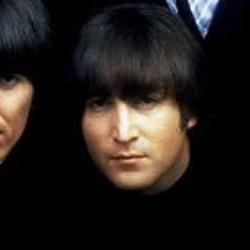

Paul_McCartney_0006.jpg :  Human detected, resembling breed found to be  Silky terrier


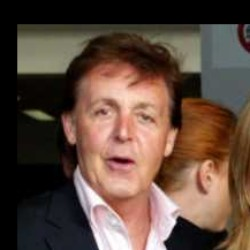

Beagle_01197.jpg :  Dog detected, breed found to be  Beagle


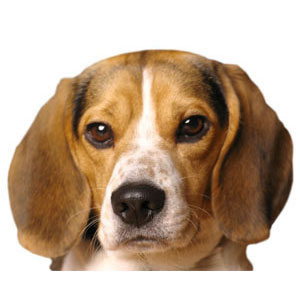

Belgian_sheepdog_01540.jpg :  Dog detected, breed found to be  Belgian sheepdog


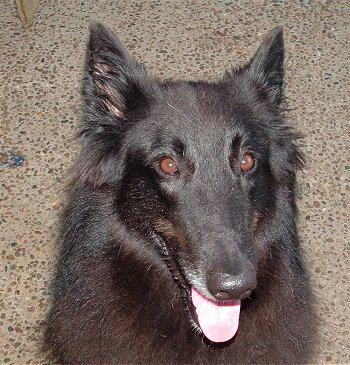

Boxer_02426.jpg :  Dog detected, breed found to be  Boxer


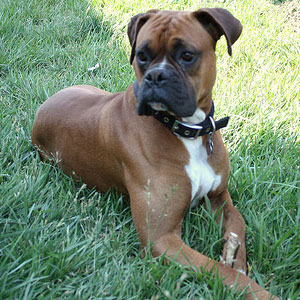

In [140]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

human_files = ['Adam_Sandler_0002.jpg', 'John_Lennon_0001.jpg', 'Paul_McCartney_0006.jpg']
dog_files = ['Beagle_01197.jpg', 'Belgian_sheepdog_01540.jpg', 'Boxer_02426.jpg']

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)